In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#start date
st = "2018-10-01"
#end date
ed = "2019-09-29"

#Select state
state_name = 'Oregon'

#https://anthonylouisdagostino.com/bounding-boxes-for-all-us-states/
#bounding box
latmin = 46.292035
latmax = 41.991794
lonmin = -116.463504
lonmax = -124.566244

wa_bounds = (-124.566244, 41.991794, -116.463504, 46.292035)
# projection
to_crs = 'epsg:4326' #WGS84

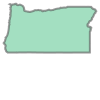

In [3]:
# projection
to_crs = 'epsg:4326' #WGS84

#State GDF
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()
states_gdf_proj = states_gdf.to_crs(to_crs)
state = states_gdf_proj.loc[states_gdf_proj['NAME'] == state_name]
geom = state.iloc[0].geometry
geom

In [4]:
geom.bounds

(-124.565973, 41.991794, -116.463504, 46.271004)

# Get SNOTEL data

In [5]:
def sites_asgdf(ulmo_getsites, crs=to_crs):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [6]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(geom.bounds[2],geom.bounds[1],geom.bounds[0],geom.bounds[3])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=to_crs)

In [7]:
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)


In [8]:
gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
gdf.drop(columns='index_right', inplace=True)
gdf.reset_index(drop=True, inplace=True)

gdf

,code,longitude,latitude,name,elevation_m,geometry
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328)
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007)
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085)
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530)
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533)
...,...,...,...,...,...,...
108,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719970703125,POINT (-118.42617 44.65567)
109,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552001953125,POINT (-122.42537 43.22718)
110,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.5439453125,POINT (-117.85050 46.11868)
111,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.44000244140625,POINT (-121.91667 45.43333)


# Get HUC data

In [9]:
import requests
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

In [10]:
def getHUC(lat, lon):
    """
    Function to get the HUC12 - HUC2 ids for a given latitude and longitude.
    Latitude and Longitude should be in WGS84 (EPSG:4326)
    """

    # the url of the web service for WBD info
    root='https://arcgis.cuahsi.org/arcgis/services/US_WBD/HUC_WBD/MapServer/WFSServer'

    # assumes that the input coords are in WGS84, i.e. EPSG:4326
    params = {'service': 'WFS',
              'request': 'GetFeature',
              'bbox': f"{lon}, {lat}, {lon}, {lat}",         
              'typeName': 'HUC_WBD:HUC12_US',
              'SrsName': 'EPSG:4326'}

    # make the WFS request
    r = requests.get(url = root, params = params, verify=False)
    
    # exit if we don't get a 200 response
    if r.status_code != 200:
        print(f'Error getting HUC for point: {lat}, {lon}')
        return None
    
    # load the response xml into memory
    root_xml =  ET.fromstring(r.text)
    
    # define xml namespaces to make parsing easier
    ns = {'xs': "http://www.w3.org/2001/XMLSchema",
          'wfs':"http://www.opengis.net/wfs/2.0",
          'gml':"http://www.opengis.net/gml/3.2",
          'US_WBD_HUC_WBD':"http://arcgis.cuahsi.org/arcgis/services/US_WBD/HUC_WBD/MapServer/WFSServer",
          'xlink':"http://www.w3.org/1999/xlink",
          'xsi': "http://www.w3.org/2001/XMLSchema-instance" 
         }
    
    # get the wfs:member element
    hucs = root_xml.findall('wfs:member', ns)
    
    # we should only get a single HUC since we're querying a point location
    huc12 = root_xml.findall('wfs:member/US_WBD_HUC_WBD:HUC12_US/US_WBD_HUC_WBD:HUC12', ns)[0].text
    
    return dict(huc12 = huc12,
                huc10 = huc12[:-2],
                huc8 = huc12[:-4],
                huc6 = huc12[:-6],
                huc4 = huc12[:-8],
                huc2 = huc12[:-10],
               )

In [11]:
h12 =[]
h10=[]
h8=[]
h6=[]
h4=[]
h2=[]
for i in gdf.index:
    try:
        hucs = getHUC(gdf.latitude[i],gdf.longitude[i])
        h12.append(hucs['huc12'])
        h10.append(hucs['huc10'])
        h8.append(hucs['huc8'])
        h6.append(hucs['huc6'])
        h4.append(hucs['huc4'])
        h2.append(hucs['huc2'])
    except:
        print(i,'error')
        gdf.drop([i], inplace=True)
    
gdf['huc12'] = h12
gdf['huc10'] = h10
gdf['huc8'] = h8
gdf['huc6'] = h6
gdf['huc4'] = h4
gdf['huc2'] = h2
gdf.reset_index(drop=True)

26 error
27 error


,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328),170601050101,1706010501,17060105,170601,1706,17
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007),180102030101,1801020301,18010203,180102,1801,18
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085),170702020604,1707020206,17070202,170702,1707,17
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530),170900040203,1709000402,17090004,170900,1709,17
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533),170501241001,1705012410,17050124,170501,1705,17
...,...,...,...,...,...,...,...,...,...,...,...,...
106,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719970703125,POINT (-118.42617 44.65567),170502020101,1705020201,17050202,170502,1705,17
107,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552001953125,POINT (-122.42537 43.22718),171003010404,1710030104,17100301,171003,1710,17
108,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.5439453125,POINT (-117.85050 46.11868),170701020303,1707010203,17070102,170701,1707,17
109,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.44000244140625,POINT (-121.91667 45.43333),170800010501,1708000105,17080001,170800,1708,17


In [12]:
gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328),170601050101,1706010501,17060105,170601,1706,17
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007),180102030101,1801020301,18010203,180102,1801,18
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085),170702020604,1707020206,17070202,170702,1707,17
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530),170900040203,1709000402,17090004,170900,1709,17
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533),170501241001,1705012410,17050124,170501,1705,17


# Get DEM data

In [ ]:
#https://github.com/UW-GDA/gda_course_2020/blob/master/modules/07_Raster2_DEMs_Warp_Clip_Sample/07_Raster2_Reprojection_Clipping_Sampling_DEMAnalysis.ipynb

In [13]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

ModuleNotFoundError: No module named 'rasterstats'

In [3]:
#Install the elevation package
!pip install elevation

     |████████████████████████████████| 71 kB 3.6 MB/s eta 0:00:011
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


In [12]:
import elevation

In [14]:
#Set some variables for the SRTM download
cache_dir='./elevation'
#We'll use the 3-arcsec products 
product='SRTM3'
#Higher-res 1-arcsec products
#product='SRTM1'
output='or_%s_full.tif' % product

In [15]:
bounds = (-124.566244, 41.991794, -116.463504, 46.292035)
#elevation.clean(cache_dir=cache_dir)
elevation.seed(bounds=geom.bounds, cache_dir=cache_dir, product=product, max_download_tiles=999)
#elevation.clip(bounds=wa_bounds, output=output, cache_dir=cache_dir, product=product, max_download_tiles=999)

NameError: name 'elevation' is not defined

In [16]:
#Check the downloaded products in the cache subdirectory
!ls -lh $cache_dir/$product/cache

total 102M
-rw-rw-r-- 1 jovyan users 25M Sep  3 02:18 srtm_12_03.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_12_03.tif.lock
-rw-rw-r-- 1 jovyan users 24M Sep  3 02:19 srtm_12_04.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_12_04.tif.lock
-rw-rw-r-- 1 jovyan users 29M Sep  3 02:20 srtm_13_03.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_13_03.tif.lock
-rw-rw-r-- 1 jovyan users 26M Sep  3 02:22 srtm_13_04.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_13_04.tif.lock


In [17]:
#Inspect the geotiff header
!gdalinfo $cache_dir/$product/cache/srtm_12_03.tif

Driver: GTiff/GeoTIFF
Files: ./elevation/SRTM3/cache/srtm_12_03.tif
Size is 6000, 6000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-125.000000000000000,50.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-125.0000000,  50.0000000) (125d 0' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-125.0000000,  45.0000000) (125d 0' 0.00"W, 4

In [18]:
# Create a vrt (virtual file) mosaic of the tif files¶
vrt_fn = '%s_wa_mosaic.vrt' % product
!gdalbuildvrt -r cubic $vrt_fn $cache_dir/$product/cache/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [19]:
!cat $vrt_fn

<VRTDataset rasterXSize="12000" rasterYSize="12000">
  <SRS dataAxisToSRSAxisMapping="2,1">GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2500000000000000e+02,  8.3333333333333339e-04,  0.0000000000000000e+00,  5.0000000000000000e+01,  0.0000000000000000e+00, -8.3333333333333339e-04</GeoTransform>
  <VRTRasterBand dataType="Int16" band="1">
    <NoDataValue>-32768</NoDataValue>
    <ColorInterp>Gray</ColorInterp>
    <ComplexSource resampling="cubic">
      <SourceFilename relativeToVRT="1">./elevation/SRTM3/cache/srtm_12_03.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="6000" RasterYSize="6000" DataType="Int16" BlockXSize="256" BlockYSize="256" />
      <SrcRect xOff="0" yOff="0" xSize="60

In [20]:
#open the vrt with rasterio
src = rio.open(vrt_fn)

In [21]:
#review metadata
src.profile

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -125.0,
       0.0, -0.0008333333333333334, 50.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

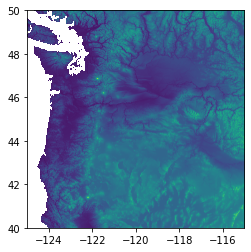

In [12]:
# plot
with rio.open(vrt_fn) as src:
    rio.plot.show(src)

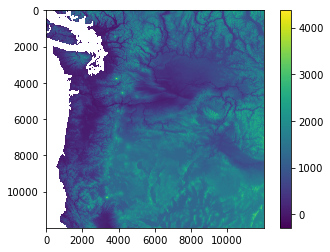

In [13]:
# Read the data and plot with matplotlib
with rio.open(vrt_fn) as src:
    f, ax = plt.subplots()
    srtm = np.ma.masked_equal(src.read(1), src.nodata)
    m = ax.imshow(srtm)
    plt.colorbar(m)

In [22]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(gdf.geometry.x,gdf.geometry.y)))

In [23]:
#sample dem
with rio.open(vrt_fn) as src:
    gdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]

# DEM to slope and aspect

In [24]:
#get indicies

with rio.open(vrt_fn) as src:
    rows, cols = rio.transform.rowcol(src.transform, gdf.geometry.x, gdf.geometry.y)

In [25]:
import richdem as rd
dem = rd.LoadGDAL(vrt_fn)

In [26]:
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')

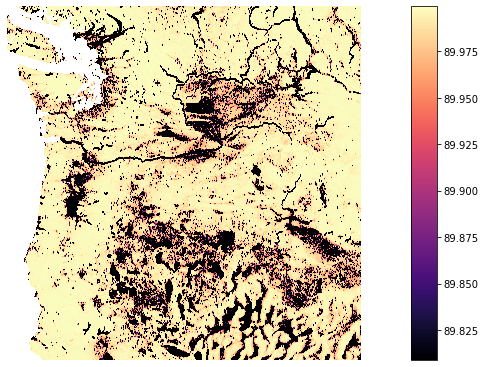

In [26]:

rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

In [27]:
#add slope to gdf
gdf['slope'] = slope[rows,cols]

In [28]:
aspect = rd.TerrainAttribute(dem, attrib='aspect')

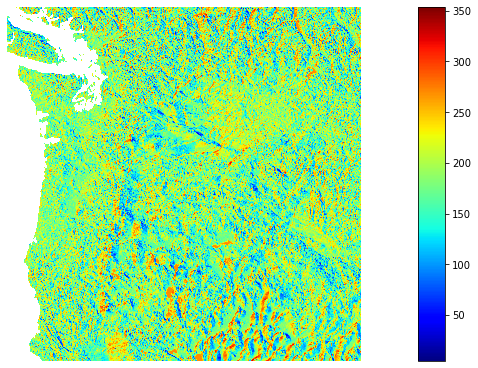

In [52]:

rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [29]:
#add aspect to gdf
gdf['aspect'] = aspect[rows,cols]

# Calculate av annual met vars 

In [30]:
import xarray as xr

# for working with geospatial data
import geopandas as gpd
from pyproj import CRS
from shapely import geometry #to define shapes and areas

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

In [31]:
ds = xr.open_dataset( "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml" )
date_start = st
date_end = ed

In [32]:
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

In [33]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'
daymet_crs = CRS.from_cf(ds[daymet_ds_grid_mapping_name].attrs)

In [34]:
bbox = box_gdf.to_crs(daymet_crs)
bbox_bounds=bbox.bounds

In [35]:
invar = 'prcp'
daymet = ds[invar].sel(
    time=slice(date_start, date_end),
    x=slice(bbox_bounds.minx[0], bbox_bounds.maxx[0]),
    y=slice(bbox_bounds.maxy[0],bbox_bounds.miny[0]) # note the reversed y values!
)
daymet

<xarray.DataArray 'prcp' (time: 364, y: 589, x: 710)>
[152221160 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1913250.0 -1912250.0 ... -1205250.0 -1204250.0
  * y        (y) float32 663000.0 662000.0 661000.0 ... 77000.0 76000.0 75000.0
  * time     (time) datetime64[ns] 2018-10-01 2018-10-02 ... 2019-09-29
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

In [36]:
print(len(np.unique(daymet['time.year'])))
np.unique(daymet['time.year'])

2


array([2018, 2019])

In [44]:
# not working yet
mn=[]
for year in np.unique(daymet['time.year']):
    data = daymet[daymet['time.year']==year]
    mn = xr.merge([mn,data.mean('time')])

/opt/conda/envs/whw/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


TypeError: objects must be an iterable containing only Dataset(s), DataArray(s), and dictionaries.

In [37]:
daymet_mean = daymet.mean('time')

In [38]:
daymet_mean

<xarray.DataArray 'prcp' (y: 589, x: 710)>
array([[      nan,       nan,       nan, ..., 2.054945 , 2.0686812,
        2.0659342],
       [      nan,       nan,       nan, ..., 2.2115386, 2.282967 ,
        2.2005494],
       [      nan,       nan,       nan, ..., 2.4423077, 2.7087913,
        2.7884614],
       ...,
       [4.447802 , 4.0274725, 3.4532967, ..., 1.6263736, 1.6401099,
        1.6593406],
       [4.2747254, 4.0961537, 3.7335165, ..., 1.5961539, 1.6043956,
        1.6291208],
       [4.2637362, 4.217033 , 3.9258242, ..., 1.6098901, 1.6071428,
        1.6098901]], dtype=float32)
Coordinates:
  * x        (x) float32 -1913250.0 -1912250.0 ... -1205250.0 -1204250.0
  * y        (y) float32 663000.0 662000.0 661000.0 ... 77000.0 76000.0 75000.0
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...

In [39]:
# reproject snotel 
reproj_gdf = gdf.to_crs(daymet_crs)
reproj_gdf

,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-1279228.522 419773.488),170601050101,1706010501,17060105,170601,1706,17,2256,89.991562,263.659821
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-1706674.973 267295.297),180102030101,1801020301,18010203,180102,1801,18,1835,89.995483,186.788971
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-1430564.283 450935.897),170702020604,1707020206,17070202,170702,1707,17,1770,89.975845,18.434948
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-1660952.227 414621.700),170900040203,1709000402,17090004,170900,1709,17,1444,89.996216,103.760788
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-1276730.839 353439.278),170501241001,1705012410,17050124,170501,1705,17,1882,89.995110,189.582947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719970703125,POINT (-1382518.410 381691.568),170502020101,1705020201,17050202,170502,1705,17,1578,89.982742,288.434937
109,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552001953125,POINT (-1716179.890 309117.008),171003010404,1710030104,17100301,171003,1710,17,988,89.975548,309.805573
110,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.5439453125,POINT (-1307053.790 523886.796),170701020303,1707010203,17070102,170701,1707,17,1686,89.980606,336.037506
111,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.44000244140625,POINT (-1617440.892 524522.519),170800010501,1708000105,17080001,170800,1708,17,1062,89.999069,150.376251


In [45]:
gdf['pr']= daymet_mean.sel(x=reproj_gdf.geometry.x, y=reproj_gdf.geometry.y, method='nearest').values[0]

In [46]:
gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect,pr
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328),170601050101,1706010501,17060105,170601,1706,17,2256,89.991562,263.659821,3.310440
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007),180102030101,1801020301,18010203,180102,1801,18,1835,89.995483,186.788971,6.601648
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085),170702020604,1707020206,17070202,170702,1707,17,1770,89.975845,18.434948,1.412088
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530),170900040203,1709000402,17090004,170900,1709,17,1444,89.996216,103.760788,6.565934
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533),170501241001,1705012410,17050124,170501,1705,17,1882,89.995110,189.582947,3.395604


In [48]:
gdf.to_csv('OR_DB.csv')

# Get time series data at stations

In [10]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [11]:
stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

302_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1000_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
304_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1166_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
324_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
331_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
341_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
343_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
344_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
351_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
357_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
361_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
362_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1109_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
388_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
395_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
398_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
401_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
406_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
422_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1010_OR_SNTL SNOTEL:WTEQ_D 2018-10-01

Unable to fetch SNOTEL:WTEQ_D
1027_OR_SNTL has no data
1028_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1028_OR_SNTL has no data
1022_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1022_OR_SNTL has no data
1023_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1023_OR_SNTL has no data
1029_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1029_OR_SNTL has no data
1021_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1021_OR_SNTL has no data
1020_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1020_OR_SNTL has no data
1019_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1019_OR_SNTL has no data
1018_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1018_OR_SNTL has no data
1025_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1025_OR_SNTL has no data
1024_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1024_OR_SNTL has no data
976_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
976_OR_SNTL has no data
477_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
479_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
483_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
945_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
494_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
504_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
523_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
526_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
529_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1158_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
259_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
259_OR_SNTL has no data
1129_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
545_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
552_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
553_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
558_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
563_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
584_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
591_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
605_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
608_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
614_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
619_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1079_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1084_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
647_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
651_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
653_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
654_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
655_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
660_OR_SNTL SNOTEL:WTEQ_D 2018-

Unable to fetch SNOTEL:WTEQ_D
263_WA_SNTL has no data
706_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
710_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
712_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
2029_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
719_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
721_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
726_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
729_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
733_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1231_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
736_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
743_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
745_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
748_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
756_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
759_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1167_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
767_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
985_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
925_OR_SNTL SNOTEL:WTEQ_D 2018-

Unable to fetch SNOTEL:WTEQ_D
1007_OR_SNTL has no data
873_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
